# Example deck for running a discontinuity tolerant DIC analysis on a set of images
This jupyter notebook contains a typical DIC procedure for obtaining fine pass and a discontinuity tolerant second pass. 

In [1]:
import os as o
from pathlib import Path
import time
import matplotlib.pyplot as plt
import crosspy as xpy

## Fill settings below

In [32]:

# Define the folder path to images
folder_path=Path(r'C:\Users\alexb\Desktop\crosspy\data\Tom')

# NOTE THAT IMAGES SHOULD BE NUMBERED AND GRAYSCALE TIFFs ARE PREFERRED

# Coarse pass settings
coarse = 150 # in pixels
coarse_overlap = 60 # in percentage

# Fine pass settings
fine = 32 # in pixels
overlap = 80 # in percentage

# Heaviside pass settings
hs_size = 32
hs_overlap = 80

# fft filter settings: high pass, high pass width, low pass, low pass width
filter_settings=[4,2,15,8]

# Parallel settings

cores = 4 # number of CPU workers



## Here we run conventional DIC to compare with later.
The coarse pass settings will have to be changed manually by the user to find an ideal size and overlap. The coarse pass displacement field is used for image correction so it is important to use appropriate settings to get the largest amount of overlapping subsets for the second pass.

It is good practice to begin by changing the coarse pass size in the variable "coarse". The goal is to use the smallest "fine" size.

Running sequential DIC on image pair 1 of 1 ...
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 572 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
... Completed in (s) 2.5139997005462646


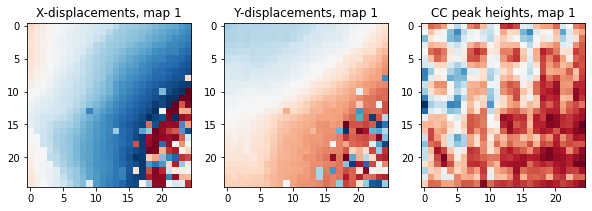

Correcting images based on DIC results ...


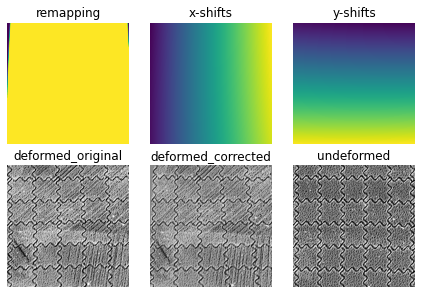

... Completed in (s) 2.1147215366363525
Running sequential DIC on image pair 1 of 1 ...
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 2040 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 13560 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 29688 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 50424 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 75768 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 76729 out of 76729 | elapsed:   20.0s finished
... Completed in (s) 20.279406309127808


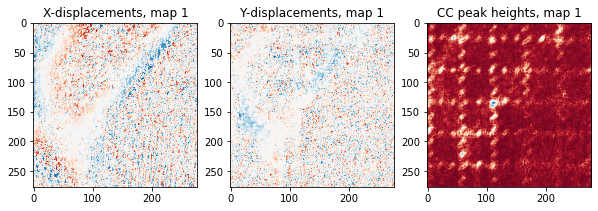

Calculating strain on map 1 of 1 ...
... Completed in (s) 37.79005408287048
Quick plotting strains


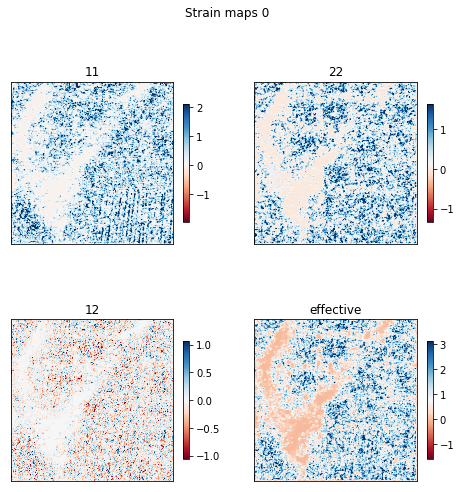

In [31]:
if __name__ == "__main__":

    # build the dic class (but don't run it yet):
    Images = xpy.Imset(folder_path,'tif',[0,1])
    roi_1stpass = dict(size_pass = coarse, overlap_percentage = coarse_overlap, xcf_mesh=coarse)
    dic_1stpass=xpy.DIC(Images,roi_1stpass,filter_settings)

    # run the dic on specified images within the stack, and get displacements:
    dic_1stpass.run_sequential(cores=cores)
    dic_1stpass.plot_displacements()

    # correct the images and instantiate a new DIC class
    corrected_images=dic_1stpass.correct(method='polynomial',printing=1)
    
    # build second pass object
    roi_2ndpass = dict(size_pass = fine, overlap_percentage = overlap, xcf_mesh=fine)
    dic_2ndpass = xpy.DIC(corrected_images,roi_2ndpass,filter_settings,savingfolder=dic_1stpass.folder)


    # # run the second pass
    dic_2ndpass.run_sequential(cores=cores)
    dic_2ndpass.plot_displacements()

    dic_2ndpass.calculate_strain()
    dic_2ndpass.plot_strains()

    #dic_2ndpass.save_data()

## Here we run a third pass based on corrected images after first pass - this pass uses the heaviside algo

Running sequential DIC on image pair 1 of 1 ..., total subsets per image: 324
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   29.0s finished
... Completed in (s) 29.119874238967896


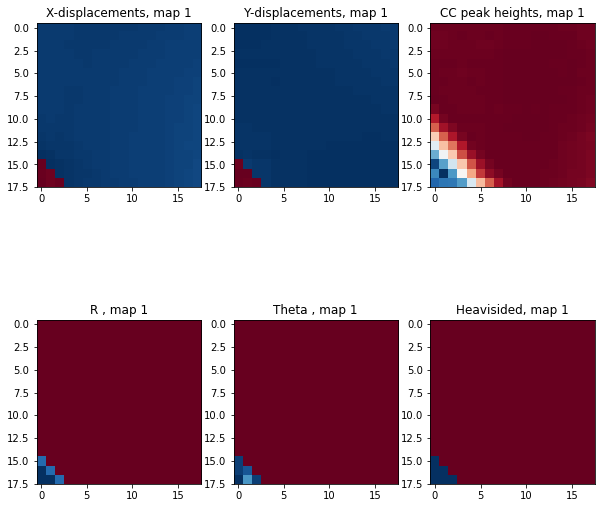

Calculating strain on map 1 of 1 ...
... Completed in (s) 0.157210111618042
Quick plotting strains


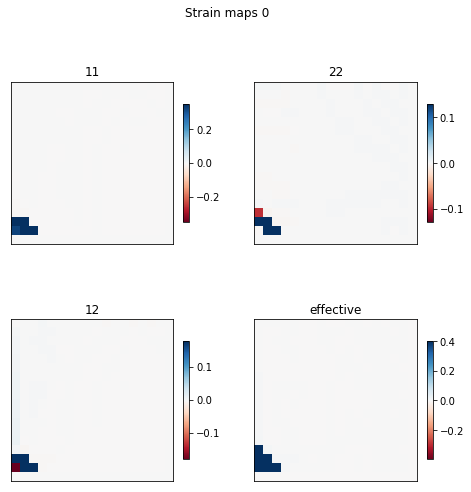

In [8]:
if __name__ == "__main__":

    roi_3rdpass = dict(size_pass = hs_size, overlap_percentage = hs_overlap, xcf_mesh=hs_size)

    dic_3rdpass = xpy.DIC(corrected_images,roi_3rdpass,filter_settings,savingfolder=dic_1stpass.folder)

    # Run the third pass with hs=true
    dic_3rdpass.run_sequential(cores=cores, hs=True, cc_t=0.)
    dic_3rdpass.plot_displacements()

    # Calculate strain
    dic_3rdpass.calculate_strain()
    dic_3rdpass.plot_strains()

## Here we plot the data in detail

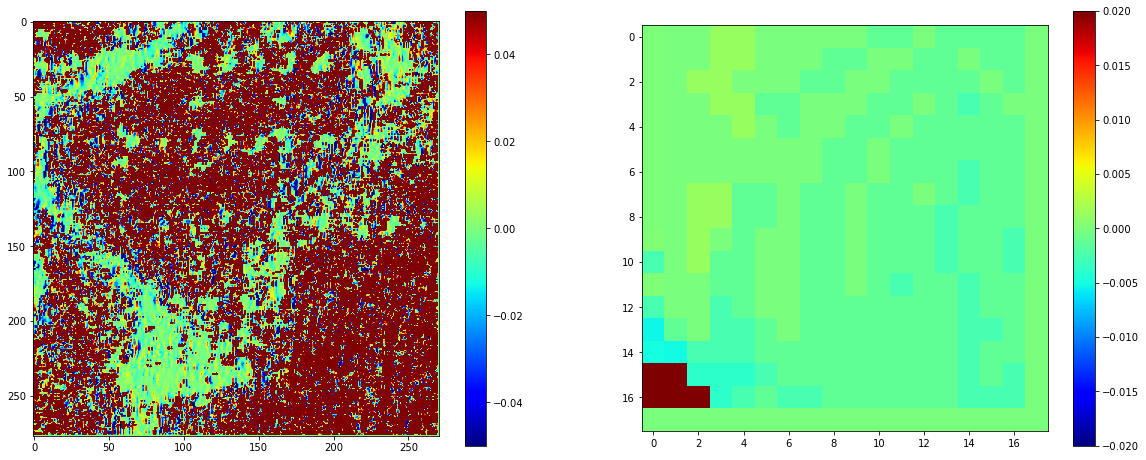

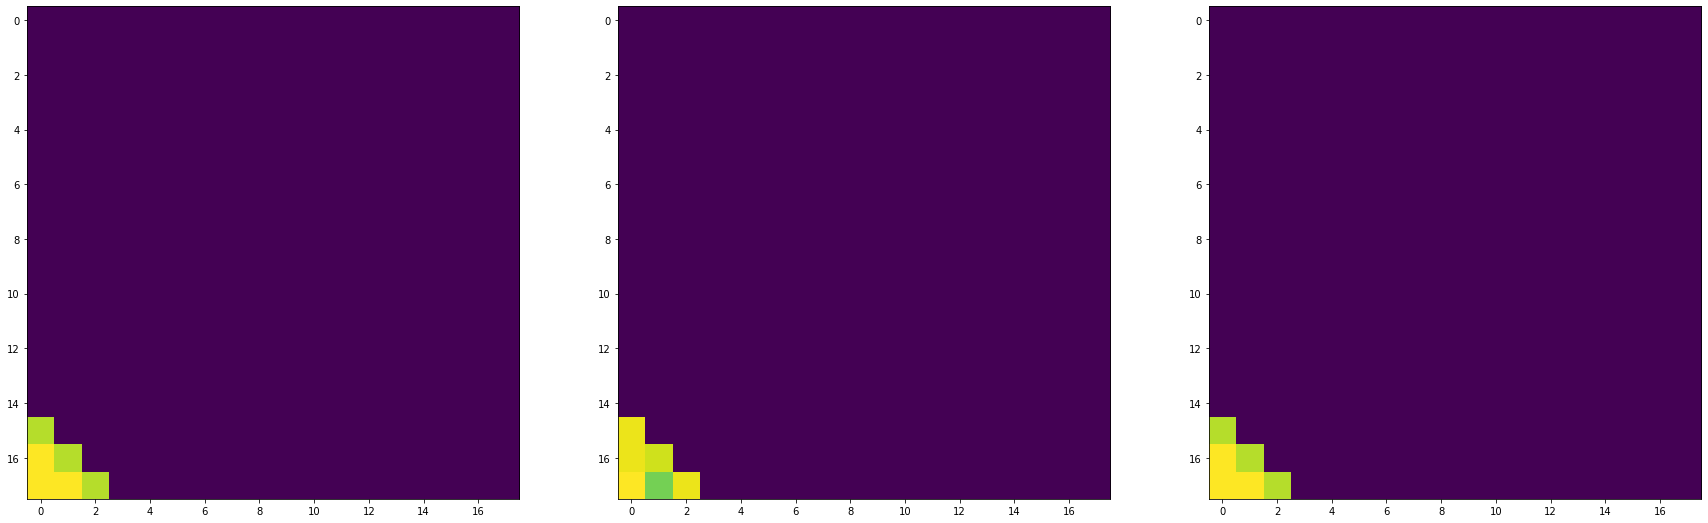

In [27]:

# XX strain data
pass_2_xx = dic_2ndpass.strain_11[:,:,0]
pass_3_xx = dic_3rdpass.strain_11[:,:,0]

# Heaviside data
r = dic_3rdpass.rd_maps[:,:,0]
t = dic_3rdpass.th_maps[:,:,0]
j = dic_3rdpass.rd_maps[:,:,0]


# Strain plot
fig1, axs = plt.subplots(1,2,figsize=(20,10))
im1 = axs[0].imshow(pass_2_xx,vmin=-0.05,vmax=0.05,cmap="jet")
im2 = axs[1].imshow(pass_3_xx,vmin=-0.02,vmax=0.02,cmap="jet")
fig1.colorbar(im1, ax=axs[0], shrink=0.8)
fig1.colorbar(im2, ax=axs[1], shrink=0.8)


# Heaviside plot
fig2, axs = plt.subplots(1,3,figsize=(30,10))
axs[0].imshow(r)
axs[1].imshow(t)
axs[2].imshow(j)


## Save data

In [ ]:
fid1 = ""
fid2 = ""
fid = o.path.join(folder_path, fid + "." + "tif")

fig1.savefig(fid1, dpi=200)
fig2.savefig(fid2, dpi=200)